# Introduction

### Background
Working in the data space for many years now, I have come to realize that there is nothing more discouraging than not having the ready dataset. In the world of data abundance, this statement may seem premature. However, let me finish my thought here. While it is true that there is more publically available data than I can ever imagine, surprising portion of it is not readily usable. Not all dataset is in impeccable condition as in the case of say, *Handwritten Digit Data Set*. 
I hit a brick wall when I searched for dataset on Korean dramas. Okay, maybe not a brick wall since I had my good friend, Wikipedia. However, even after using Wikipedia's media API, I had to go through couple iterations of data cleansing process to transform the raw text into a Pandas dataframe. I decided to share the dataset here so anybody who wants it does not have to go through the same frustration I had. 

### Why Dataset on Korean Dramas?
To be honest, I do not watch Korean dramas. I am more of hollywood-made crime/suspense kind of girl. So why Korean dramas? Because I like making something interesting from a blob of data. Too simple? If this were an interview question, I will put more effort into my answer and say the followings: 
#### (1) K-dramas' unique properties that are different from that of western TV series
Korean dramas have gained popularity over the years. Among many reasons why they appeal to a wide range of audience - both in Asia and in Western countries - attractive cast, plot twists, and famous screen writer/director come to my mind. I want to analyze each K-drama in depth, but it will be an another (*big*) project for another time. 
#### (2) Lack of fun dataset in Korean language
There really isn't much. 

### About myself
I am [Doran Bae](https://www.linkedin.com/in/doranbae/), a data scientist working on recommendations in the entertainment industry. I have a Masters degree from UC Berkeley in Master of Information and Data Science ([MIDS](https://www.linkedin.com/school/15139744/)). I am into NLP these days. 

## Now let's see what I am working with...
All the data was gathered using Wikipedia (Korean version) API.

In [16]:
import pickle
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
file_name = 'data/movie_df.pkl'
movie_pk = open(file_name, 'rb')
movie_df = pickle.load(movie_pk)
print("Loaded k-drama meta dataset : ", len(movie_df), " dramas")

Loaded k-drama meta dataset :  379  dramas


In [273]:
movie_df[31:32]

,title,title_id,tag,genre,summary_detail,episode_nums,episode_duration,title_name,main_cast,staff,plot,topic,origin
31,최고의_한방,31,"[연예계, 2017, 여행, 예능, 금토, 시간]","[드라마, 청춘]",《'''최고의 한방'''》은 [[2017년]] [[6월 2일]]부터 [[2017년]...,32,35,최고의 한방,"[윤시윤, 이세영 (배우), 김민재 (1996년), 차태현, 동현배]","[유호진, 최지영, 서수민]","사랑하고, 이야기하고, 먹고 사는 것을 치열하게 고민하는 이 시대의 20대 청춘 소란극.",-1,-1


* title: A field that is used as a search key in Wikipedia.
* title_id: ID associated with titles
* title_name: Drama title in plain Korean. Later I plan to use this as a key to scrape more data from other sources
* tag: Tags associated with each title
* genre: Genre associated with each title
* summary_detail: The first paragraph in every title's wikipedia page. Later I plan to vectorize this in feature engineering
* episode_nums: Number of episodes. Dose not include special/spin-off episodes
* episode_duration: Duration of each episode in minutes
* main_cast: All the casts in the drama. Later I plan to divied this into main and sub casts 
* staff: All the staff (including directors, writers, or artists) associated with each title
* plot: Plot of the drama
* topic: Main topic of the drama
* origin: Origin of the drama
</br>
</br>
Disclaimer: This is the result of my first iteration. I admit the dataset is far from being perfect. I will continue to update the dataset to ensure quality and robustness. All the missing data is represented as -1. 

## How clean or good is it?
Let's look at how much of the data is not null. 

In [30]:
colum_list = movie_df.columns.tolist()

In [34]:
for col in column_list:
    values = movie_df[col].tolist()
    null_count = values.count(-1)
    not_null_ratio = float((len(values) - null_count)/len(values))
    print(col, not_null_ratio)

title 1.0
title_id 1.0
tag 0.9525065963060686
genre 0.9920844327176781
summary_detail 0.9182058047493403
episode_nums 0.9155672823218998
episode_duration 0.6147757255936676
title_name 0.9102902374670184
main_cast 0.920844327176781
staff 0.316622691292876
plot 0.3720316622691293
topic 0.002638522427440633
origin 0.002638522427440633


## Some fields are in pretty good shape, some are in dire straits.
It looks like of the 379 drama titles, 90% of them have reliable source of tag, genre, summary, episodes, and main cast.

# Time to explore the dataset!

### What is the most popular genre?

In [309]:
file_name = 'data/genre_df.pkl'
genre_df_pk = open(file_name, 'rb')
genre_df = pickle.load(genre_df_pk)

In [311]:
file_name = 'data/rv_genre_index_dict.pkl'
genre_index_pk = open(file_name, 'rb')
rv_genre_index_dict = pickle.load(genre_index_pk)

In [314]:
genre_df['genre'] = genre_df['genre_id'].apply(lambda x: rv_genre_index_dict.get(x))
genre_df.at[18,"genre"] = "드라마" #Merging
genre_df[:3]

,genre_id,count,genre
18,27,211,드라마
5,37,27,-1
11,14,26,멜로


### Okay, if you do not know Korean, you have no idea that 'drama (드라마)' is the most popular genre. Let's translate this into English 

In [52]:
file_name = 'data/kor_eng_genre_dict.pkl'
kor_eng_genre_dict_pkl = open(file_name, 'rb')
kor_eng_mapp_dict = pickle.load(kor_eng_genre_dict_pkl)

In [316]:
genre_df["genre_en"] = genre_df["genre"].apply(lambda x: kor_eng_mapp_dict.get(x, -1))

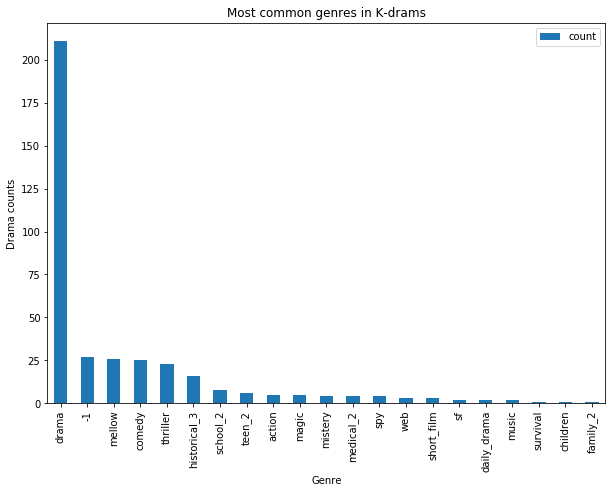

In [317]:
data = genre_df[["genre_en", "count"]]
ax = data.plot(kind = "bar", title = "Most common genres in K-drams", figsize = (10,7))
ax.set_xticklabels(data.genre_en)
plt.xlabel("Genre")
plt.ylabel("Drama counts")
plt.show()

### Make more sense?
The suffix (as in *medical**_2***) is because I have not merged similar genres yet. Let's see which genres occure in presence of one another the most.

## Pairwise analysis of K-drama genres
### Get drama genre information from each drama

In [145]:
# We will only work with movies with two or more genre classifications
movie_df_pairwise = movie_df.loc[movie_df['genre'] != -1]
print(movie_df_pairwise.shape)
movie_df_pairwise = movie_df_pairwise[movie_df_pairwise['genre'].map(len) > 1]
print(movie_df_pairwise.shape)

(376, 13)
(121, 13)


In [148]:
drama_genre_dict = movie_df_pairwise[["title","genre"]].set_index("title").T.to_dict("list")
print(len(drama_genre_dict.keys()))

121


In [154]:
#all_genre

In [163]:
all_genre = [f for s in movie_df_pairwise["genre"].tolist() for f in s]
all_genre = list(set(all_genre))

genre_index_df = pd.DataFrame({'genre': pd.Series(all_genre).values, 'genre_index' : np.arange(len(all_genre))})
genre_index_dict = genre_index_df.set_index('genre').T.to_dict('list')
reverse_genre_index_dict = genre_index_df.set_index('genre_index').T.to_dict('list')
reverse_genre_index_dict[-1] = 'None' # Add null dictionary

In [165]:
drama_titles = movie_df_pairwise["title"].tolist()
drama_genre_index_dict = {}

for drama in drama_titles:
    genre = drama_genre_dict[drama]
    genre = [k for j in genre for k in j]
    genre_list = []
    for item in genre:
        g_index = genre_index_dict.get(item, [-1])
        genre_list.extend(g_index)
    drama_genre_index_dict[drama] = genre_list

In [166]:
len(drama_genre_index_dict.keys())

121

In [167]:
# Test
print(drama_genre_dict.get("성균관_스캔들"))
print(drama_genre_index_dict["성균관_스캔들"])

[['드라마', '로맨스', '사극', '팩션', '코미디']]
[10, 13, 8, 28, 23]


### Pair co-occuring genres and count the frequency

In [169]:
def get_genre_pairs(genre_list):
    pairs = []
    pairs = list(itertools.combinations(genre_list,2))
    return pairs

In [170]:
possible_pairs = []
for drama in drama_titles:
    possible_pairs.extend(get_genre_pairs(drama_genre_index_dict[drama]))

In [171]:
nr_ids = np.unique(possible_pairs)

In [178]:
visGrid = np.zeros((len(nr_ids), len(nr_ids)))

In [181]:
for p in possible_pairs:
    visGrid[np.argwhere(nr_ids == p[0]), np.argwhere(nr_ids == p[1])]+=1
    if p[1] != p[0]:
        visGrid[np.argwhere(nr_ids == p[1]), np.argwhere(nr_ids == p[0])] += 1

In [182]:
print (visGrid.shape)
print (len(reverse_genre_index_dict.keys()))

(37, 37)
38


In [186]:
new_eng_reverse_genre_index_dict = {}
for i in list(reverse_genre_index_dict.keys()):
    kor_ = reverse_genre_index_dict[i]
    kor_ =  "".join(str(x) for x in kor_)
    eng_ = kor_eng_mapp_dict.get(kor_, "No Genre")
    new_eng_reverse_genre_index_dict[i] = eng_

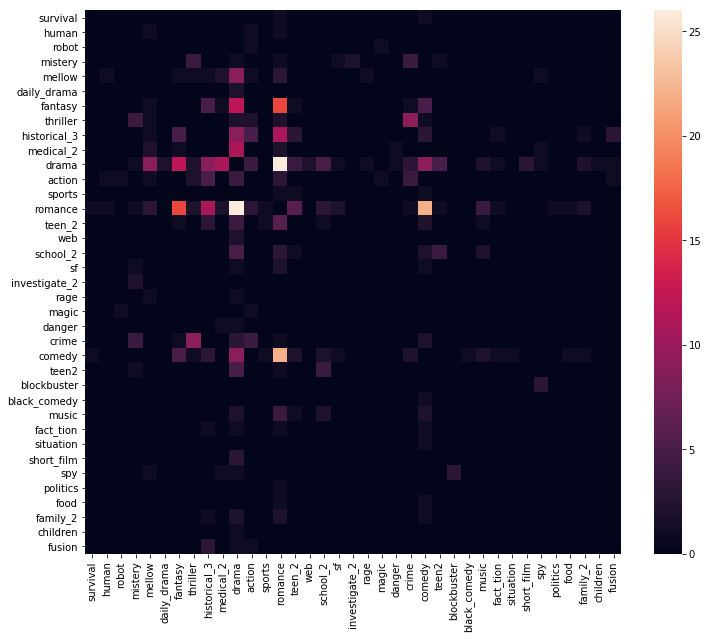

In [322]:
genre_lookup = []
for i in range(len(nr_ids)):
    genre_lookup.append(new_eng_reverse_genre_index_dict[nr_ids[i]])
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(visGrid, xticklabels=genre_lookup, yticklabels=genre_lookup)

### No surprise here. Romance+drama is a popular combination
In addition to romance drama, I can also observe comedy+romance, romance+fantasy, and drama+fantasy to be more popular above others

## Most appearing actors/actresses

In [207]:
file_name = 'data/cast_df.pkl'
cast_df_pkl = open(file_name, 'rb')
cast_df = pickle.load(cast_df_pkl)

In [238]:
cast_df[:5]

,cast,count
650,주상욱,7
378,민호,7
293,김래원,7
462,이보영 (배우),6
398,류승수,6


In [232]:
def in_movies(cast_name):
    played_in = []
    for title in movie_df["title"].tolist():
        main_actor = movie_df.loc[movie_df["title"] == title]["main_cast"].tolist()
        try:
            main_cast = [f for j in main_actor for f in j]
        except:
            main_cast = [-1]
        if cast_name in main_cast:
            played_in.append(title)
    return played_in

Top appearing actors/actresses and list of dramas they played in.

In [237]:
top_n = 5
top_n_df = cast_df[:top_n]
for idx, cast in enumerate(top_n_df["cast"].tolist()):
    print(idx+1, '_', cast)
    movies_in = in_movies(cast)
    print(*movies_in, sep = '\n')
    print("")

1 _ 주상욱
특수사건_전담반_TEN_2
자이언트_(드라마)
굿_닥터_(2013년_드라마)
판타스틱_(드라마)
특수사건_전담반_TEN
그저_바라보다가
네_꿈을_펼쳐라

2 _ 민호
달려라_고등어
도롱뇽도사와_그림자_조작단
푸른_바다의_전설
꽃보다_남자_(대한민국_드라마)
두근두근_체인지
황금의_제국
화랑_(드라마)

3 _ 김래원
펀치_(드라마)
내_사랑_팥쥐
흑기사_(드라마)
닥터스_(드라마)
학교_2_(드라마)
넌_어느_별에서_왔니
옥탑방_고양이

4 _ 이보영 (배우)
적도의_남자
너의_목소리가_들려
서동요_(드라마)
해후
미스터_굿바이
신의_선물_-_14일

5 _ 류승수
펀치_(드라마)
시리우스_(드라마)
황금의_제국
아름다운_나의_신부
마술학교
추적자_THE_CHASER



## Most frequent tags

In [242]:
file_name = 'data/tag_df.pkl'
tag_df_pkl = open(file_name, 'rb')
tag_df = pickle.load(tag_df_pkl)

In [245]:
tag_df[:3]

,tag,count
51,월화,114
150,로맨스,106
187,2010대,68


In [204]:
top_n = 5
top_n_df = cast_df[:top_n]
for idx, cast in enumerate(top_n_df["cast"].tolist()):
    print(idx+1, '_', cast)
    movies_in = in_movies(cast)
    print(*movies_in, sep = '\n')
    print("")

In [269]:
def find_tags(tag):
    tag_in = []
    for title in movie_df["title"].tolist():
        tags = movie_df.loc[movie_df["title"] == title]["tag"].tolist()
        try:
            tags = [f for j in tags for f in j]
        except:
            tags = [-1]
        if tag in tags:
            tag_in.append(title)
    return tag_in

In [271]:
top_n = 5
top_n_df = tag_df[:top_n]
for idx, tag in enumerate(top_n_df["tag"].tolist()):
    print(idx+1, '_', tag)
    movies_with_tag = find_tags(tag)
    print(*movies_with_tag[:3], sep = '\n')
    print("...")
    print("")

1 _ 월화
전설의_고향_-_1999년
펀치_(드라마)
구름계단_(2006년_드라마)
...

2 _ 로맨스
시카고_타자기_(드라마)
구름계단_(2006년_드라마)
성균관_스캔들
...

3 _ 2010대
시카고_타자기_(드라마)
애타는_로맨스
상속자들
...

4 _ 수목
아르곤_(2003년_드라마)
역도요정_김복주
추리의_여왕
...

5 _ 2017
시카고_타자기_(드라마)
반지의_여왕
애타는_로맨스
...

